In [2]:
import mne
from flask_cors import CORS
from flask import Flask, request, jsonify
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import resample
import mne
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.ticker as ticker

In [2]:
edf_path = 'sample_psg.edf'
raw = mne.io.read_raw_edf(edf_path, preload=True)
print(raw.info)

Extracting EDF parameters from c:\Users\sendm\Desktop\Programming\Code\Python\Python\SPA\flask_server\sample_psg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5529599  =      0.000 ... 27647.995 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: F3-M2, F4-M1, C3-M2, C4-M1, CZ-M1, O1-M2, O2-M1, E1-M2, E2-M1, ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2013-04-02 22:21:57 UTC
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 4 items (dict)
>


In [103]:
print(len(raw[0][0][0]))

5529600


Extracting EDF parameters from c:\Users\sendm\Desktop\Programming\Code\Python\Python\SPA\flask_server\sample_psg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5529599  =      0.000 ... 27647.995 secs...


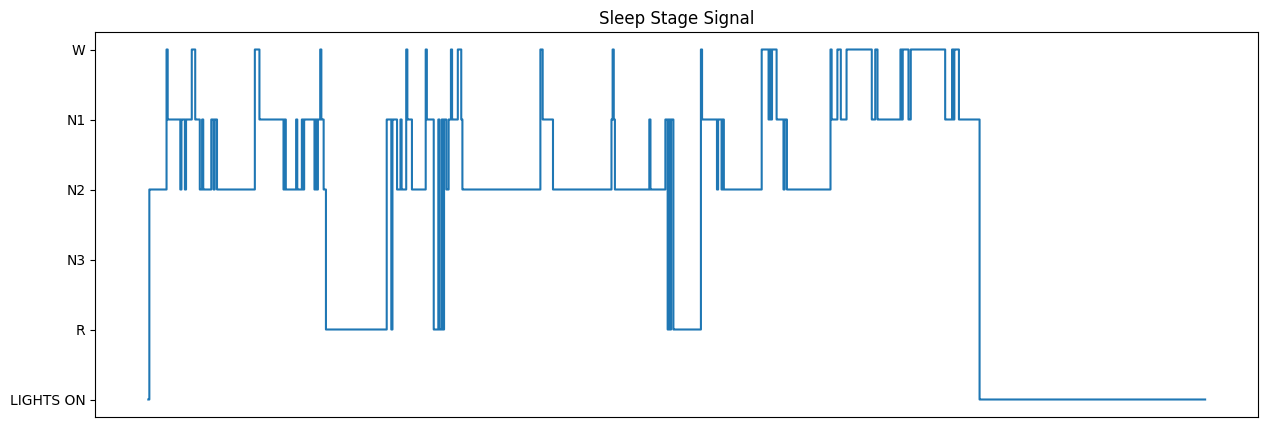

In [4]:
pd.options.mode.chained_assignment = None
annotations_df = pd.read_csv('sample_psg_annotations.csv')

# Extract sleep stage annotations
sleep_stages = annotations_df[annotations_df['event'].str.startswith('Sleep_stage_')].copy()

# Convert the 'time' column to datetime
sleep_stages.loc[:, 'time'] = pd.to_datetime(sleep_stages['time'], format='%H:%M:%S').dt.time

# Define a mapping from sleep stages to numerical values
sleep_stage_mapping = {
    'Sleep_stage_W': 4,
    'Sleep_stage_N1': 3,
    'Sleep_stage_N2': 2,
    'Sleep_stage_N3': 1,
    'Sleep_stage_R': 0,
    'Sleep_stage_?': -1,
    'Arousal - RespEvent - 1': -1,
    'Position - Left - 1': -1,
    'Treatment - None - 1': -1,
    'LIGHTS OUT': -1,
    'PLM - Periodic - 1': -1,
    'RespEvent - RERA - 6': -1,
    'RespEvent - Hypopnea - 4': -1,
    'RespEvent - ObstructiveApnea - 1': -1,
    'Position - Right - 1': -1,
    'Position - Supine - 1': -1,
    'PLM - Isolated - 1': -1,
    'RespEvent - CentralApnea - 2': -1,
    'LIGHTS ON': -1
}

y_tick_labels = {value: key.replace('Sleep_stage_', '') for key, value in sleep_stage_mapping.items()}

sleep_stages = sleep_stages.reset_index()

sleep_stages = sleep_stages.rename(columns={'time':'start', 'duration':'end'})

for i in range(len(sleep_stages)):
    t=sleep_stages['start'][i]
    total_seconds = t.hour * 3600 + t.minute * 60 + t.second
    end_time = total_seconds + sleep_stages['end'][i]
    sleep_stages['start'][i] = total_seconds
    sleep_stages['end'][i] = end_time

    event = sleep_stages['event'][i]
    stage = sleep_stage_mapping.get(event, -1)
    sleep_stages['event'][i] = stage

max_length = sleep_stages['end'].max()

sleep_stage_signal = np.full(int(max_length), np.nan)

for k in range(len(sleep_stages)):
    sleep_stage_signal[int(sleep_stages['start'][k]):int(sleep_stages['end'][k])] = int(sleep_stages['event'][k])

sleep_stage_signal = np.nan_to_num(sleep_stage_signal, nan=-1)


edf_path = 'sample_psg.edf'
raw = mne.io.read_raw_edf(edf_path, preload=True)

fs = raw.info['sfreq']
total_duration = (raw.n_times)/fs

sleep_stage_signal = sleep_stage_signal[:int(total_duration)]

sleep_stage_signal_resampled = []
for i in range(len(sleep_stage_signal)):
    val = sleep_stage_signal[i]

    for k in range(200):
        sleep_stage_signal_resampled.append(val)

# num_samples = int(total_duration * fs)
# sleep_stage_signal_resampled = resample(sleep_stage_signal, num_samples)
sleep_stage_signal_resampled = np.array(sleep_stage_signal_resampled)

plt.figure(figsize=(15, 5))
plt.plot(raw.times, sleep_stage_signal_resampled, label='Sleep Stages', drawstyle='steps-post')

# Format the x-axis to display time in hh:mm:ss format
# plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: pd.to_datetime(x, unit='s').strftime('%H:%M:%S')))

# plt.xlabel('Time (hh:mm:ss)')
plt.xticks([])
plt.yticks(ticks=list(y_tick_labels.keys()), labels=list(y_tick_labels.values()))
plt.title('Sleep Stage Signal')
plt.show()


Using matplotlib as 2D backend.


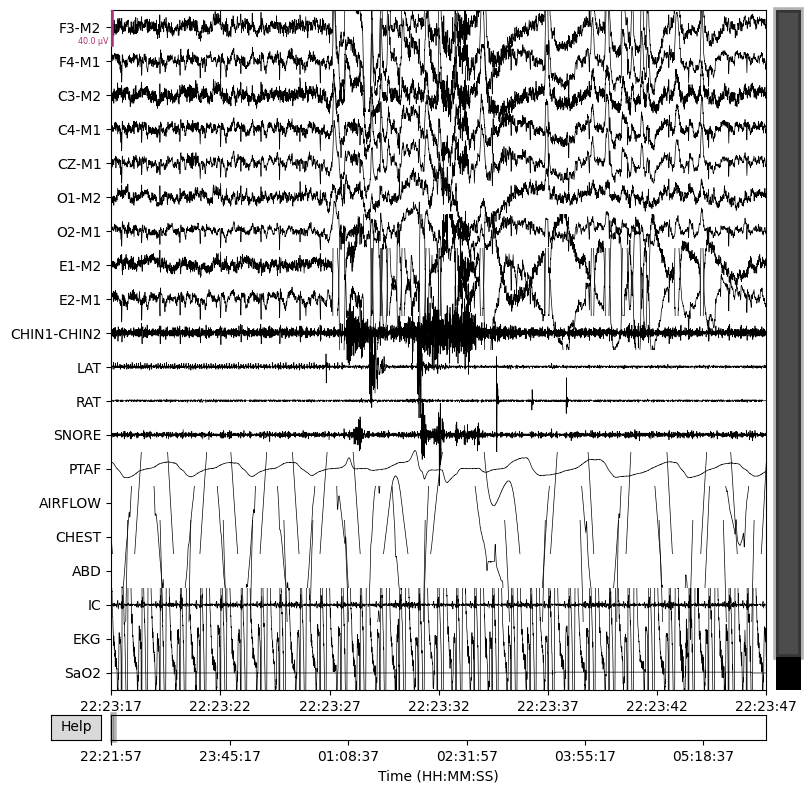

In [3]:
import numpy as np
# events = np.array([[int(100 * raw.info['sfreq']), 0, 1]])  # Event at 100 seconds

# Assuming 'raw' is your raw data object
events, event_dict = mne.events_from_annotations(raw)
fig = raw.plot(start=80, duration=30, events=events, event_color='r', time_format = 'clock')  # 'r' for red color



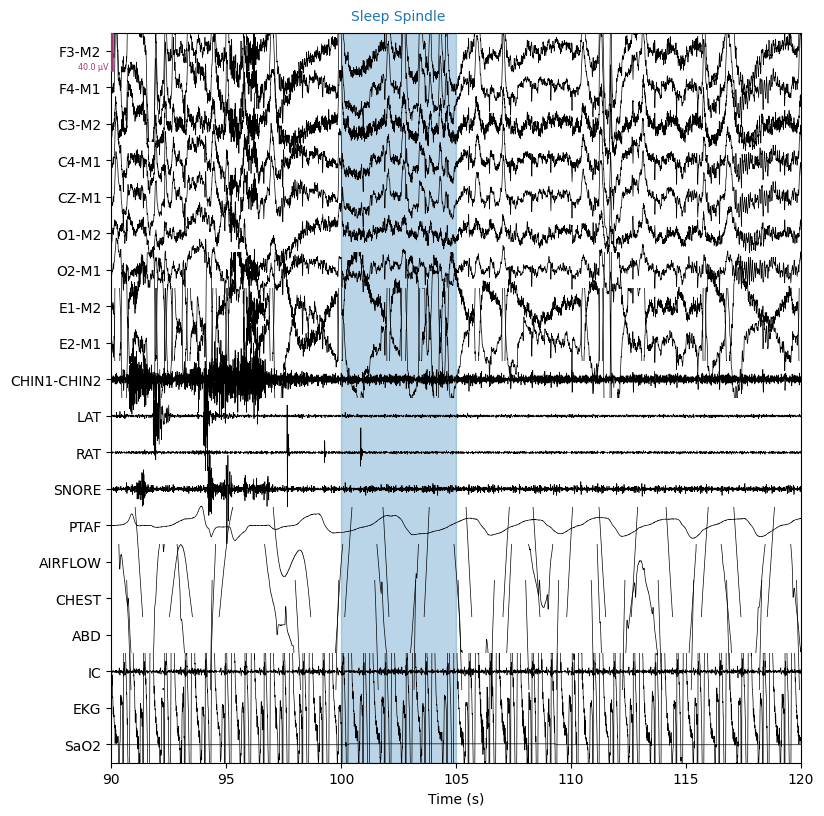

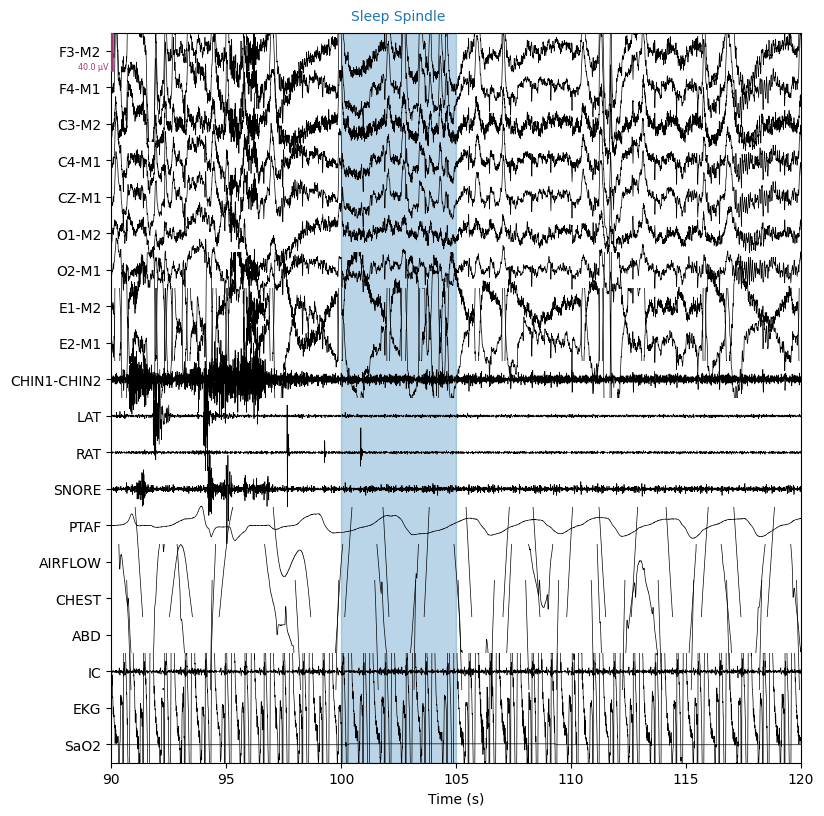

In [15]:
my_annotations = mne.Annotations(onset=[100], duration=[5], description=['Sleep Spindle'])
raw.set_annotations(my_annotations)
raw.plot(start=90, duration=30, show_scrollbars=False)


In [ ]:
for i in range(10):
    fig = raw.plot(n_channels = 21, start = i*30, duration = 30)
    fig.savefig(f'images\image_{i}.png')

In [5]:
file_path = 'sample_psg.edf'
raw = mne.io.read_raw_edf(file_path, preload=True)

# List the channels you want to include
channels = ['F3-M2', 'F4-M1', 'C3-M2', 'C4-M1', 'CZ-M1', 'O1-M2', 'O2-M1', 'E1-M2', 'E2-M1', 'CHIN1-CHIN2', 'LAT', 'RAT', 'SNORE', 'PTAF', 'AIRFLOW', 'CHEST', 'ABD', 'IC', 'EKG', 'SaO2', 'HR']

Extracting EDF parameters from c:\Users\sendm\Desktop\Programming\Code\Python\Python\SPA\flask_server\sample_psg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5529599  =      0.000 ... 27647.995 secs...


Extracting EDF parameters from c:\Users\sendm\Desktop\Programming\Code\Python\Python\SPA\flask_server\sample_psg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5529599  =      0.000 ... 27647.995 secs...
Using matplotlib as 2D backend.


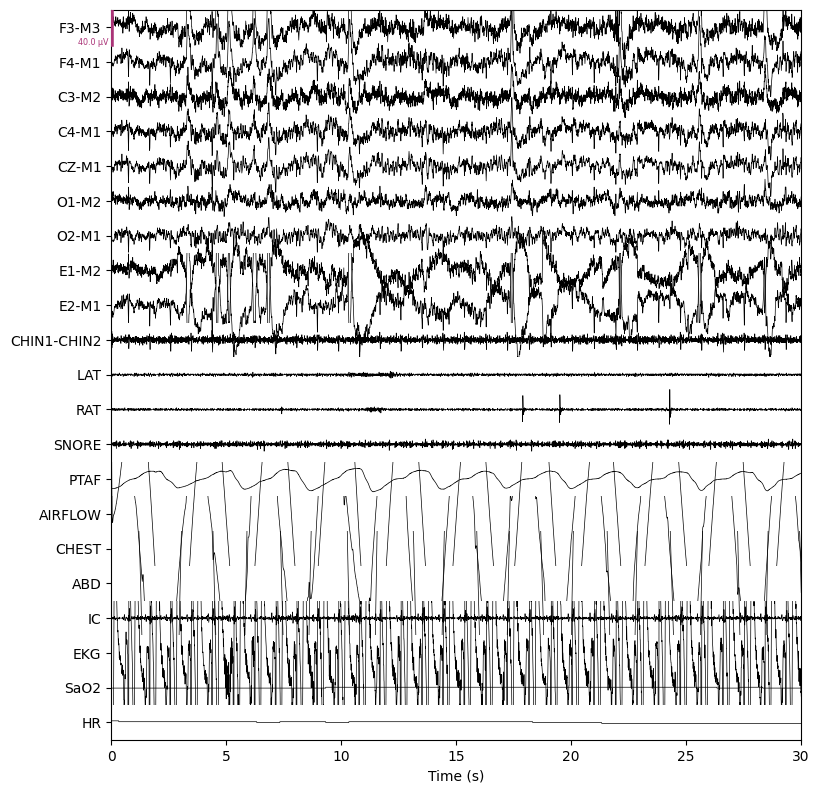

In [6]:
import mne

def load_and_rename_channels(file_path, channel_names_by_index):
    """
    Load an EDF file and rename channels based on user input.
    
    Parameters:
        file_path (str): Path to the EDF file.
        channel_names_by_index (dict): Dictionary mapping indices to standardized channel names.
        
    Returns:
        mne.io.Raw: Raw object with channels renamed.
    """
    # Load the raw data
    raw = mne.io.read_raw_edf(file_path, preload=True)
    
    # Get current channel names
    current_channel_names = raw.ch_names
    
    # Create a new list of channel names based on user input
    new_channel_names = current_channel_names[:]  # Make a copy to keep original intact
    for index, name in channel_names_by_index.items():
        if index < len(new_channel_names):
            new_channel_names[index] = name
    
    # Rename the channels
    rename_mapping = dict(zip(current_channel_names, new_channel_names))
    raw.rename_channels(rename_mapping)
    
    return raw

# Example of user input
user_specified_mapping = {
    0: 'F3-M3',
    1: 'F4-M1',
    2: 'C3-M2',
    3: 'C4-M1',
    4: 'CZ-M1',
    5: 'O1-M2',
    6: 'O2-M1',
    7: 'E1-M2',
    8: 'E2-M1',
    9: 'CHIN1-CHIN2',
    10: 'LAT',
    11: 'RAT',
    12: 'SNORE',
    13: 'PTAF',
    14: 'AIRFLOW',
    15: 'CHEST',
    16: 'ABD',
    17: 'IC',
    18: 'EKG',
    19: 'SaO2',
    20: 'HR'
}

raw = load_and_rename_channels(file_path, user_specified_mapping)

# Now you can plot the raw data or perform further analysis

fig = raw.plot(n_channels = 21, start = 0, duration = 30, show_scrollbars=False)
fig.savefig(f'images\image_10.png')


Extracting EDF parameters from c:\Users\sendm\Desktop\Programming\Code\Python\Python\SPA\flask_server\sample_psg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5529599  =      0.000 ... 27647.995 secs...


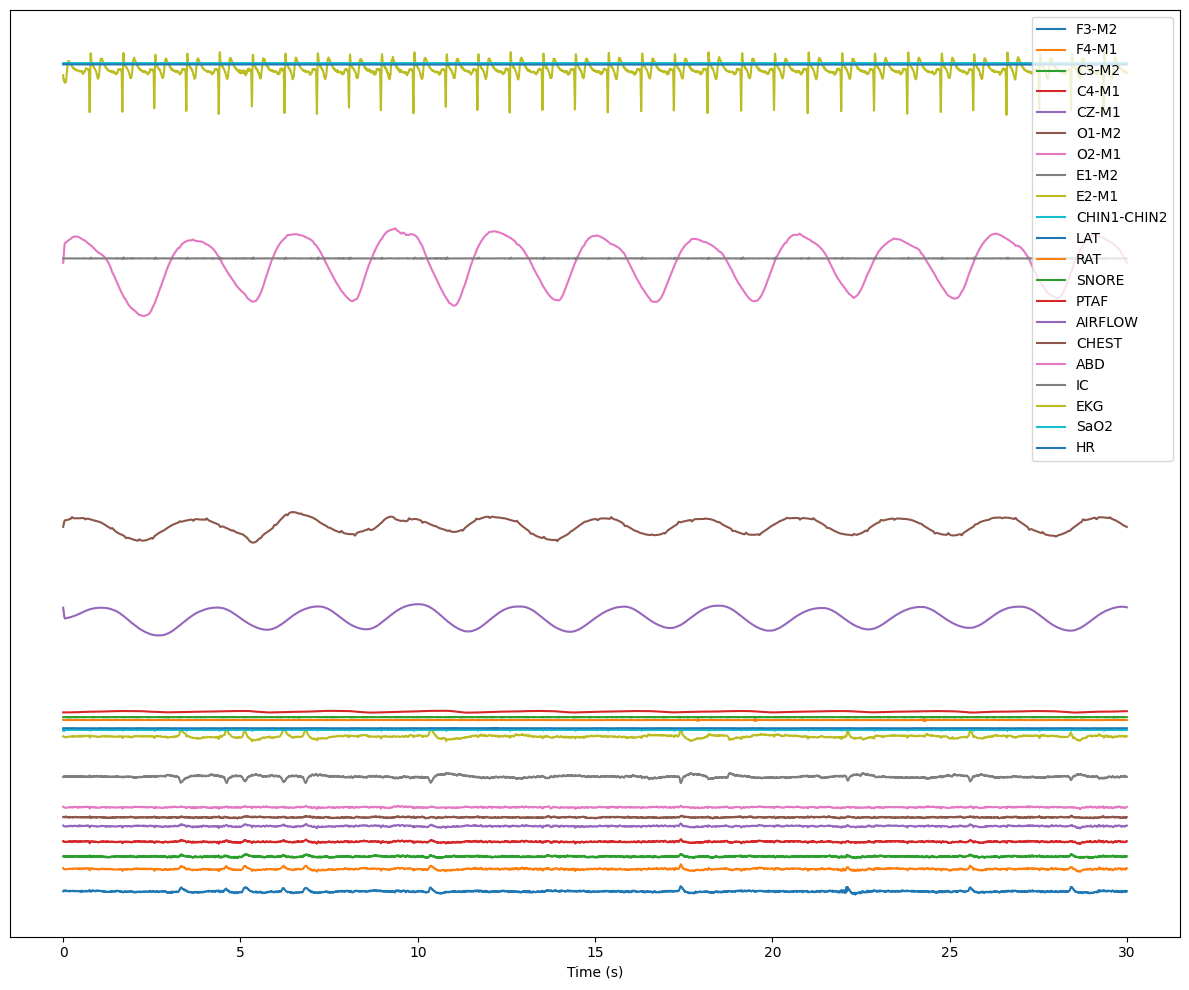

In [2]:
import mne
import matplotlib.pyplot as plt
import numpy as np

def plot_edf_channels_single_plot(raw, channels, time_length):
    """
    Plots the channels of an EDF file in a single plot, with each channel starting from its own baseline without altering the signal.

    Parameters:
        raw (mne.io.Raw): Pre-loaded raw data object.
        channels (list): List of channel names to plot.
        time_length (float): Length of time to plot in seconds.
    """
    # Create a figure
    fig, ax = plt.subplots(figsize=(12, 10))

    # Determine time indices
    start_time = 0  # You can adjust this if you want to start plotting from a different time
    end_time = start_time + time_length
    start_idx, end_idx = raw.time_as_index([start_time, end_time])

    # Initialize an offset
    offset = 0
    offset_increment = 0  # We will calculate an appropriate increment based on the signal amplitude

    # Calculate an initial offset increment based on the first channel if available
    if channels[0] in raw.ch_names:
        data, _ = raw[channels[0], start_idx:end_idx]
        offset_increment = 3 * np.ptp(data)  # Using peak-to-peak amplitude to define offset

    # Plot each channel with a vertical offset
    for i, ch_name in enumerate(channels):
        if ch_name in raw.ch_names:
            data, times = raw[ch_name, start_idx:end_idx]
            # Calculate new offset increment dynamically for each channel
            current_offset_increment = 3 * np.ptp(data)  # Adjust the multiplier as needed
            offset += current_offset_increment if i > 0 else 0  # Increment offset after the first channel
            ax.plot(times, data[0] + offset, label=ch_name)

    ax.set_xlabel('Time (s)')
    ax.set_yticks([])  # Remove y-tick labels for clarity
    ax.legend(loc='upper right')  # Optional, remove if cluttered
    plt.tight_layout()
    plt.show()

# Example usage
file_path = 'sample_psg.edf'  # Adjust the path as needed
raw = mne.io.read_raw_edf(file_path, preload=True)
channels = ['F3-M2', 'F4-M1', 'C3-M2', 'C4-M1', 'CZ-M1', 'O1-M2', 'O2-M1', 'E1-M2', 'E2-M1', 'CHIN1-CHIN2', 'LAT', 'RAT', 'SNORE', 'PTAF', 'AIRFLOW', 'CHEST', 'ABD', 'IC', 'EKG', 'SaO2', 'HR']
plot_edf_channels_single_plot(raw, channels, 30)  # Adjust the time length as needed
